In [1]:
import os #RICK STUFF
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

import pydot
from io import StringIO
from sklearn.tree import export_graphviz

In [2]:
df = pd.read_csv('STUDENT.csv')

In [3]:
# Task 1.1
df['G3'].value_counts()

PASS    661
FAIL    383
Name: G3, dtype: int64

In [4]:
# Task 1.2
def preprocess():
    import pandas as pd
    #Preprocess data
    df_raw = pd.read_csv('STUDENT.csv', index_col=0)
    df = df_raw.drop(['InitialName', 'guardian'], axis=1)
    
    # Map binaries
    df['address'] = df['address'].map({ 'U':0, 'R':1 })
    df['sex'] = df['sex'].map({ 'M':0, 'F':1 })
    df['famsize'] = df['famsize'].map({ 'LE3':0, 'GT3':1 })
    df['Pstatus'] = df['Pstatus'].map({ 'A':0, 'T':1 })
    df['schoolsup'] = df['schoolsup'].map({ 'no':0, 'yes':1 })
    df['famsup'] = df['famsup'].map({ 'no':0, 'yes':1 })
    df['paid'] = df['paid'].map({ 'no':0, 'yes':1 })
    df['activities'] = df['activities'].map({ 'no':0, 'yes':1 })
    df['nursery'] = df['nursery'].map({ 'no':0, 'yes':1 })
    df['higher'] = df['higher'].map({ 'no':0, 'yes':1 })
    df['internet'] = df['internet'].map({ 'no':0, 'yes':1 })
    df['romantic'] = df['romantic'].map({ 'no':0, 'yes':1 })
    df['G3'] = df['G3'].map({ 'FAIL': 0, 'PASS': 1 })

    # Fill via median for age
    df['age'].fillna(df['age'].median(), inplace=True)
    df['age'] = df['age'].astype(int)
    
    # Fill via 'none' since hot encode will flag
    df['school'].fillna('none', inplace=True)
    df['reason'].fillna('none', inplace=True)

    # Task 1.3
    #Drop g1 & 2 empty rows
    df = df.drop(['G1', 'G2', 'failures'], axis=1)

    # Hot encode
    df = pd.get_dummies(df)
    return df

In [5]:
def analyse_feature_importance(dm_model, feature_names, n_to_display=20):
    # grab feature importances from the model
    importances = dm_model.feature_importances_

    # sort them out in descending order
    indices = np.argsort(importances)
    indices = np.flip(indices, axis=0)
    # limit to 20 features, you can leave this out to print out everything
    indices = indices[:n_to_display]
    for i in indices:
        print(feature_names[i], ':', importances[i])
        
def visualize_decision_tree(dm_model, feature_names, save_name):
    dotfile = StringIO()
    export_graphviz(dm_model, out_file=dotfile, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dotfile.getvalue())
    graph[0].write_png(save_name) # saved in the following file CHANGED TO ACCESS INDEX

In [6]:
df = preprocess()

In [7]:
#
# Start of Task 2
#

In [8]:
# Task 2.1
y = df['G3']
x = df.drop(['G3'], axis=1)

# set seed for randomisation
rs = 10

# Convert x into numpy matrix for sklearn consumption
x_mat = x.as_matrix()
# Setup training and test datasets on a 70/30 split
x_train, x_test, y_train, y_test = train_test_split(x_mat, y, test_size=0.3, stratify=y, random_state=rs)

# simple decision tree training
model = DecisionTreeClassifier()
model.fit(x_train, y_train)
print(model)
# Check accuracy on the training sets
print("Train accuracy:", model.score(x_train, y_train))
# Check accuracy on the test sets
print("Test accuracy:", model.score(x_test, y_test))

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

# Check which features have the largest impact on the decision tree?

# grab feature importances from the model and feature name from the original x
importances = model.feature_importances_
feature_names = x.columns

# sort in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 5 features
indices = indices[:5]

for i in indices:
    print(feature_names[i], ':', importances[i])
    
# visualize
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=x.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph[0].write_png("default_decision.png") # CHANGED TO ACCESS [0] element

C:\Users\rickm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Train accuracy: 0.9972602739726028
Test accuracy: 0.5859872611464968
             precision    recall  f1-score   support

          0       0.44      0.49      0.46       115
          1       0.68      0.64      0.66       199

avg / total       0.60      0.59      0.59       314

absences : 0.10550797145257432
higher : 0.06658724391357355
age : 0.06488616852719159
famrel : 0.05092426783243271
health : 0.05048499450681311


In [9]:
# Task 2.1.b 
# Decision Rules
# Code provided by paulkernfeld, stackoverflow
from sklearn.tree import _tree
def tree_to_code(tree, feature_names, Y):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    pathto=dict()

    global k
    k = 0
    def recurse(node, depth, parent):
        global k
        indent = "  " * depth

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            s= "{} <= {} ".format( name, threshold, node )
            if node == 0:
                pathto[node]=s
            else:
                pathto[node]=pathto[parent]+' & ' +s

            recurse(tree_.children_left[node], depth + 1, node)
            s="{} > {}".format( name, threshold)
            if node == 0:
                pathto[node]=s
            else:
                pathto[node]=pathto[parent]+' & ' +s
            recurse(tree_.children_right[node], depth + 1, node)
        else:
            k=k+1
            print(k,')',pathto[parent], tree_.value[node])
    recurse(0, 1, 0)

tree_to_code(model, x.columns, y)

1 ) higher <= 0.5  & famrel <= 1.5  [[0. 3.]]
2 ) higher <= 0.5  & famrel > 1.5 & age <= 16.5  & Pstatus <= 0.5  [[2. 0.]]
3 ) higher <= 0.5  & famrel > 1.5 & age <= 16.5  & Pstatus > 0.5 & sex <= 0.5  & reason_course <= 0.5  & romantic <= 0.5  [[0. 2.]]
4 ) higher <= 0.5  & famrel > 1.5 & age <= 16.5  & Pstatus > 0.5 & sex <= 0.5  & reason_course <= 0.5  & romantic > 0.5 [[1. 0.]]
5 ) higher <= 0.5  & famrel > 1.5 & age <= 16.5  & Pstatus > 0.5 & sex <= 0.5  & reason_course > 0.5 [[2. 0.]]
6 ) higher <= 0.5  & famrel > 1.5 & age <= 16.5  & Pstatus > 0.5 & sex > 0.5 [[0. 3.]]
7 ) higher <= 0.5  & famrel > 1.5 & age > 16.5 & school_none <= 0.5  & Mjob_at_home <= 0.5  & Fjob_at_home <= 0.5  [[28.  0.]]
8 ) higher <= 0.5  & famrel > 1.5 & age > 16.5 & school_none <= 0.5  & Mjob_at_home <= 0.5  & Fjob_at_home > 0.5 & Dalc <= 1.5  & absences <= 3.0  [[1. 0.]]
9 ) higher <= 0.5  & famrel > 1.5 & age > 16.5 & school_none <= 0.5  & Mjob_at_home <= 0.5  & Fjob_at_home > 0.5 & Dalc <= 1.5  & abs

In [10]:
# Task 2.2
print("Wide search to find optimal depth and leaf range:\n")
# grid search CV 1
params = {'criterion': ['gini', 'entropy'],
 'max_depth': range(2, 10),
 'min_samples_leaf': range(20, 60, 10)}
cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs),cv=10)
cv.fit(x_train, y_train)
print("Train accuracy:", cv.score(x_train, y_train))
print("Test accuracy:", cv.score(x_test, y_test))
# test the best model
y_pred = cv.predict(x_test)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv.best_params_)


print("\n\n\nSpecified search to find optimal depth and leaf:\n")
# grid search CV 2
params = {'criterion': ['gini', 'entropy'],
 'max_depth': range(2, 10),
 'min_samples_leaf': range(24, 37)}
cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs),cv=10)
cv.fit(x_train, y_train)
tree_optimal = cv.best_estimator_
print("Train accuracy:", cv.score(x_train, y_train))
print("Test accuracy:", cv.score(x_test, y_test))
# test the best model
y_pred = cv.predict(x_test)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv.best_params_)

# print the feature importance and save the decision tree
analyse_feature_importance(cv.best_estimator_, x.columns, 5)
visualize_decision_tree(cv.best_estimator_, x.columns, "optimal_decision.png")

Wide search to find optimal depth and leaf range:

Train accuracy: 0.7219178082191781
Test accuracy: 0.6592356687898089
             precision    recall  f1-score   support

          0       0.54      0.50      0.52       115
          1       0.72      0.75      0.74       199

avg / total       0.65      0.66      0.66       314

{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 30}



Specified search to find optimal depth and leaf:

Train accuracy: 0.7178082191780822
Test accuracy: 0.643312101910828
             precision    recall  f1-score   support

          0       0.51      0.51      0.51       115
          1       0.72      0.72      0.72       199

avg / total       0.64      0.64      0.64       314

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 34}
higher : 0.3133028333660085
school_DCHS : 0.131807588885754
absences : 0.11448145286961198
Fedu : 0.1088873310214518
traveltime : 0.07112199333165148


In [11]:
#
# Start of Task 3
#

In [12]:
# Task 3.1
# Scale all data to have a mean of 0
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train, y_train)
x_test = scaler.transform(x_test)

C:\Users\rickm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
# Task 3.2 default
model = LogisticRegression(random_state=rs)
# fit it to training data
model.fit(x_train, y_train)
reg_def = model
print(reg_def)
print("\n\n")


# training and test accuracy
print("Train accuracy:", model.score(x_train, y_train))
print("Test accuracy:", model.score(x_test, y_test))
# classification report on test data
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))


feature_names = x.columns
coef = model.coef_[0]
# limit to 5 features
coef = coef[:5]
for i in range(len(coef)):
    print(feature_names[i], ':', coef[i])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)



Train accuracy: 0.7342465753424657
Test accuracy: 0.6910828025477707
             precision    recall  f1-score   support

          0       0.60      0.46      0.52       115
          1       0.73      0.82      0.77       199

avg / total       0.68      0.69      0.68       314

sex : 0.2431274764602015
age : -0.26578375258821146
address : -0.004342089777775582
famsize : -0.061954211352185325
Pstatus : -0.05565581730388714


In [14]:
# Taks 3.2 optimal
# grid search CV
params = {'C': [pow(10, x) for x in range(-8, 6)]}
# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),cv=10, n_jobs=-1)
cv.fit(x_train, y_train)
reg_optimal = cv.best_estimator_
print(reg_optimal)
print("\n\n")
# test the best model
print("Train accuracy:", cv.score(x_train, y_train))
print("Test accuracy:", cv.score(x_test, y_test))
y_pred = cv.predict(x_test)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv.best_params_)
print("\n\n")

# feature importance
coef = cv.best_estimator_.coef_[0]
feature_names = x.columns
# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
# limit to 5 features
indices = indices[:5]
for i in indices:
    print(feature_names[i], ':', coef[i])


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)



Train accuracy: 0.7342465753424657
Test accuracy: 0.6847133757961783
             precision    recall  f1-score   support

          0       0.59      0.46      0.52       115
          1       0.72      0.81      0.77       199

avg / total       0.67      0.68      0.67       314

{'C': 0.01}



higher : 0.23371581544712633
Fedu : 0.1642605037006509
studytime : 0.1578461574317443
schoolsup : -0.14956293036187407
absences : -0.14085175238070663


In [15]:
#
# Reasoning for log transformation
#

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_skewed_columns(df):
    # setting up subplots for easier visualisation
    f, axes = plt.subplots(2,6, figsize=(10,10), sharex=False)
    # gift avg plots
    sns.distplot(df['age'].dropna(), hist=False, ax=axes[0,0])
    sns.distplot(df['absences'].dropna(), hist=False, ax=axes[0,1])
    sns.distplot(df['Medu'].dropna(), hist=False, ax=axes[0,2])
    sns.distplot(df['Fedu'].dropna(), hist=False, ax=axes[0,3])
    sns.distplot(df['traveltime'].dropna(), hist=False, ax=axes[0,4])
    sns.distplot(df['studytime'].dropna(), hist=False, ax=axes[0,5])
    sns.distplot(df['famrel'].dropna(), hist=False, ax=axes[1,0])
    sns.distplot(df['freetime'].dropna(), hist=False, ax=axes[1,1])
    sns.distplot(df['goout'].dropna(), hist=False, ax=axes[1,2])
    sns.distplot(df['Dalc'].dropna(), hist=False, ax=axes[1,3])
    sns.distplot(df['Walc'].dropna(), hist=False, ax=axes[1,4])
    sns.distplot(df['health'].dropna(), hist=False, ax=axes[1,5])
    plt.show()

plot_skewed_columns(df)

<Figure size 1000x1000 with 12 Axes>

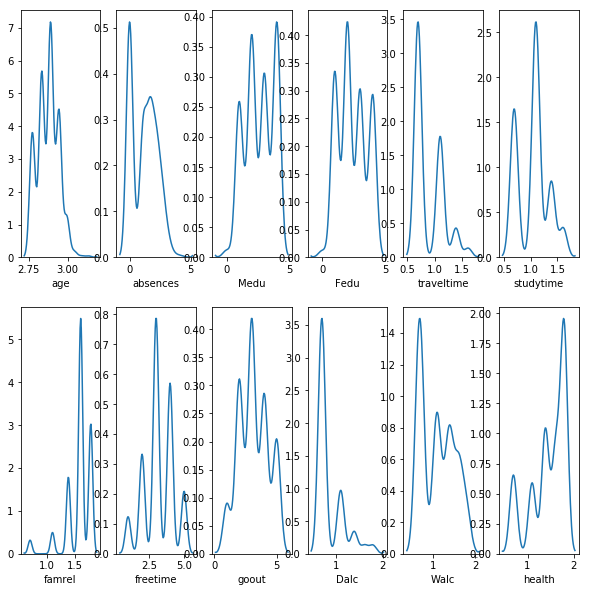

In [17]:
import numpy as np
# list columns to be transformed
columns_to_transform = ['absences', 'age', 'traveltime', 'studytime', 'famrel', 'Dalc', 'Walc', 'health']
# copy the dataframe
df_log = df.copy()
# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)
# plot them again to show the distribution
plot_skewed_columns(df_log)

In [18]:
y_log = df_log['G3']
x_log = df_log.drop(['G3'], axis=1)
x_mat_log = x_log.as_matrix()
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x_mat_log, y_log, test_size=0.3, 
                                                                    stratify=y_log, random_state=rs)
# standardise them again
scaler_log = StandardScaler()
x_train_log = scaler_log.fit_transform(x_train_log, y_train_log)
x_test_log = scaler_log.transform(x_test_log)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),
cv=10, n_jobs=-1)
cv.fit(x_train_log, y_train_log)

reg_log = cv.best_estimator_

# test the best model
print("Train accuracy:", cv.score(x_train_log, y_train_log))
print("Test accuracy:", cv.score(x_test_log, y_test_log))

y_pred = cv.predict(x_test_log)
print(classification_report(y_test_log, y_pred))

# print parameters of the best model
print(cv.best_params_)

C:\Users\rickm\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Train accuracy: 0.7301369863013699
Test accuracy: 0.6656050955414012
             precision    recall  f1-score   support

          0       0.56      0.43      0.48       115
          1       0.71      0.80      0.75       199

avg / total       0.65      0.67      0.65       314

{'C': 0.1}


In [19]:
#
# Log transformations decrease accuracy and therefore are not being implemented for optimal solution
#

In [20]:
# Task 3.3
from sklearn.feature_selection import RFECV
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(x_train, y_train) # run the RFECV
# comparing how many variables before and after
print("Original feature set", x_train.shape[1])
print("Number of features after elimination", rfe.n_features_)
print("\n")

x_train_sel = rfe.transform(x_train)
x_test_sel = rfe.transform(x_test)

# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),
cv=10, n_jobs=-1)
cv.fit(x_train_sel, y_train)
reg_rfe = cv.best_estimator_
# test the best model
print("Train accuracy:", cv.score(x_train_sel, y_train))
print("Test accuracy:", cv.score(x_test_sel, y_test))
y_pred = cv.predict(x_test_sel)
print(classification_report(y_test, y_pred))
# print parameters of the best model
print(cv.best_params_)
print("\n\n")

# feature importance
coef = cv.best_estimator_.coef_[0]
feature_names = x.columns
# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
# dont limit so to see what variables are remaining
for i in indices:
    print(feature_names[i], ':', coef[i])

Original feature set 42
Number of features after elimination 8


Train accuracy: 0.7246575342465753
Test accuracy: 0.7038216560509554
             precision    recall  f1-score   support

          0       0.65      0.41      0.50       115
          1       0.72      0.87      0.79       199

avg / total       0.69      0.70      0.68       314

{'C': 0.01}



Pstatus : 0.25954544916308686
age : 0.20186423266937298
traveltime : 0.18888114692732919
address : 0.1647436010725625
Medu : -0.15674241032230216
famsize : -0.14083837845407723
sex : -0.13913099704037202
Fedu : -0.1287181174041425


In [21]:
# running RFE + log transformation
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(x_train_log, y_train_log) # run the RFECV on log transformed dataset
# comparing how many variables before and after
print("Original feature set", x_train_log.shape[1])
print("Number of features after elimination", rfe.n_features_)
# select features from log transformed dataset
x_train_sel_log = rfe.transform(x_train_log)
x_test_sel_log = rfe.transform(x_test_log)
# init grid search CV on transformed dataset
params = {'C': [pow(10, x) for x in range(-6, 4)]}
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),
cv=10, n_jobs=-1)
cv.fit(x_train_sel_log, y_train_log)
reg_rfe_log = cv.best_estimator_
# test the best model
print("Train accuracy:", cv.score(x_train_sel_log, y_train_log))
print("Test accuracy:", cv.score(x_test_sel_log, y_test_log))
y_pred_log = cv.predict(x_test_sel_log)
print(classification_report(y_test_log, y_pred_log))
# print parameters of the best model
print(cv.best_params_)

Original feature set 42
Number of features after elimination 36
Train accuracy: 0.7232876712328767
Test accuracy: 0.6624203821656051
             precision    recall  f1-score   support

          0       0.55      0.43      0.49       115
          1       0.71      0.79      0.75       199

avg / total       0.65      0.66      0.65       314

{'C': 0.01}


In [22]:
y_reg_def = reg_def.predict(x_test)
y_reg_optimal = reg_optimal.predict(x_test)
y_reg_log = reg_log.predict(x_test)
y_reg_rfe = reg_rfe.predict(x_test_sel)
y_reg_rfe_log = reg_rfe_log.predict(x_test_sel_log)
print("Accuracy score on test for default regression:", accuracy_score(y_test, y_reg_def))
print("Accuracy score on test for GridSearchCV regression:", accuracy_score(y_test, y_reg_optimal))
print("Accuracy score on test for logged GridSearchCV regression:", accuracy_score(y_test, y_reg_log))
print("Accuracy score on test for RFE GridSearchCV regression:", accuracy_score(y_test, y_reg_rfe))
print("Accuracy score on test for logged RFE GridSearchCV regression:", accuracy_score(y_test, y_reg_rfe_log))

Accuracy score on test for default regression: 0.6910828025477707
Accuracy score on test for GridSearchCV regression: 0.6847133757961783
Accuracy score on test for logged GridSearchCV regression: 0.6687898089171974
Accuracy score on test for RFE GridSearchCV regression: 0.7038216560509554
Accuracy score on test for logged RFE GridSearchCV regression: 0.6624203821656051


In [23]:
from sklearn.metrics import roc_auc_score
y_proba_reg_def = reg_def.predict_proba(x_test)
y_proba_reg_optimal = reg_optimal.predict_proba(x_test)
y_proba_reg_log = reg_log.predict_proba(x_test)
y_proba_reg_rfe = reg_rfe.predict_proba(x_test_sel)
y_proba_reg_rfe_log = reg_rfe_log.predict_proba(x_test_sel_log)

roc_index_reg_def = roc_auc_score(y_test, y_proba_reg_def[:, 1])
roc_index_reg_optimal = roc_auc_score(y_test, y_proba_reg_optimal[:, 1])
roc_index_reg_log = roc_auc_score(y_test, y_proba_reg_log[:, 1])
roc_index_reg_rfe = roc_auc_score(y_test, y_proba_reg_rfe[:, 1])
roc_index_reg_rfe_log = roc_auc_score(y_test, y_proba_reg_rfe_log[:, 1])

print("ROC index on test for default regression:", roc_index_reg_def)
print("ROC index on test for GridSearchCV regression:", roc_index_reg_optimal)
print("ROC index on test for logged GridSearchCV regression:", roc_index_reg_log)
print("ROC index on test for RFE GridSearchCV regression:", roc_index_reg_rfe)
print("ROC index on test for logged RFE GridSearchCV regression:", roc_index_reg_rfe_log)

ROC index on test for default regression: 0.6760323355909985
ROC index on test for GridSearchCV regression: 0.6783919597989949
ROC index on test for logged GridSearchCV regression: 0.6728424732357441
ROC index on test for RFE GridSearchCV regression: 0.6874371859296482
ROC index on test for logged RFE GridSearchCV regression: 0.6759012453572208


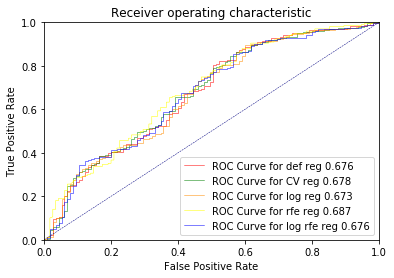

In [24]:
from sklearn.metrics import roc_curve
fpr_reg_def, tpr_reg_def, thresholds_reg_def = roc_curve(y_test, y_proba_reg_def[:,1])
fpr_reg_optimal, tpr_reg_optimal, thresholds_reg_optimal = roc_curve(y_test, y_proba_reg_optimal[:,1])
fpr_reg_log, tpr_reg_log, thresholds_reg_log = roc_curve(y_test, y_proba_reg_log[:,1])
fpr_reg_rfe, tpr_reg_rfe, thresholds_reg_rfe = roc_curve(y_test, y_proba_reg_rfe[:,1])
fpr_reg_rfe_log, tpr_reg_rfe_log, thresholds_reg_rfe_log = roc_curve(y_test, y_proba_reg_rfe_log[:,1])

import matplotlib.pyplot as plt

plt.plot(fpr_reg_def, tpr_reg_def, label='ROC Curve for def reg {:.3f}'.format(roc_index_reg_def), color='red', lw=0.5)
plt.plot(fpr_reg_optimal, tpr_reg_optimal, label='ROC Curve for CV reg {:.3f}'.format(roc_index_reg_optimal), color='green', lw=0.5)
plt.plot(fpr_reg_log, tpr_reg_log, label='ROC Curve for log reg {:.3f}'.format(roc_index_reg_log), color='darkorange', lw=0.5)
plt.plot(fpr_reg_rfe, tpr_reg_rfe, label='ROC Curve for rfe reg {:.3f}'.format(roc_index_reg_rfe), color='yellow', lw=0.5)
plt.plot(fpr_reg_rfe_log, tpr_reg_rfe_log, label='ROC Curve for log rfe reg {:.3f}'.format(roc_index_reg_rfe_log), color='blue', lw=0.5)

# plt.plot(fpr[2], tpr[2], color='darkorange',
# lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [25]:
#
# Start of Task 4
#

In [54]:
# Task 4 Prep
# Reset and scale vals
columns_to_transform = ['absences', 'age']
df_log = df.copy()
# transform the columns with np.log
for col in columns_to_transform:
    df_log[col] = df_log[col].apply(lambda x: x+1)
    df_log[col] = df_log[col].apply(np.log)
y_log = df['G3']
x_log = df.drop(['G3'], axis=1)
x_mat_log = x.as_matrix()
x_train_log, x_test_log, y_train_log, y_test_log = train_test_split(x_mat_log, y_log, test_size=0.3, stratify=y, random_state=rs)
scaler = StandardScaler()
x_train_log = scaler.fit_transform(x_train_log, y_train_log)
x_test_log = scaler.transform(x_test_log)

y = df['G3']
x = df.drop(['G3'], axis=1)
x_mat = x.as_matrix()
x_train, x_test, y_train, y_test = train_test_split(x_mat, y, test_size=0.3, stratify=y, random_state=rs)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train, y_train)
x_test = scaler.transform(x_test)

C:\Users\rickm\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\rickm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rickm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rickm\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\rickm\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version

In [27]:
# Task 4.1.a
# NN with default settings
# Given that the network cant converge with max_iter=200 set to best val so reasonable outputs obtained
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=400, random_state=rs)
model.fit(x_train, y_train)
print('Using normal test and train')
print("Train accuracy:", model.score(x_train, y_train))
print("Test accuracy:", model.score(x_test, y_test))
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))
print(model)

print('\nUsing log test and train')
from sklearn.neural_network import MLPClassifier
NND_model = MLPClassifier(max_iter=400, random_state=rs)
NND_model.fit(x_train_log, y_train)

print("Train accuracy:", NND_model.score(x_train_log, y_train_log))
print("Test accuracy:", NND_model.score(x_test_log, y_test_log))
y_pred_log = NND_model.predict(x_test_log)
print(classification_report(y_test_log, y_pred_log))
print(NND_model)

Using normal test and train
Train accuracy: 0.9904109589041096
Test accuracy: 0.6656050955414012
             precision    recall  f1-score   support

          0       0.54      0.53      0.54       115
          1       0.73      0.74      0.74       199

avg / total       0.66      0.67      0.66       314

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Using log test and train
Train accuracy: 0.9904109589041096
Test accuracy: 0.6656050955414012
             precision    recall  f1-score   support

          0       0.54      0.53      0.54       115
          1       0.73      0.74      0.74       199



In [28]:
# Iterations required
print(NND_model.n_iter_)

327


In [29]:
#Shape
print(x_train.shape)

(730, 42)


In [30]:
# Task 4.1.b
# NN with GridSearchCV settings
params = {'hidden_layer_sizes': [(x,) for x in range(2, 43, 5)]}
cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=600, random_state=rs), cv=10, n_jobs=-1)
cv.fit(x_train, y_train)
print("Train accuracy:", cv.score(x_train, y_train))
print("Test accuracy:", cv.score(x_test, y_test))
y_pred = cv.predict(x_test)
print(classification_report(y_test, y_pred))
print(cv.best_params_)

Train accuracy: 0.9904109589041096
Test accuracy: 0.6687898089171974
             precision    recall  f1-score   support

          0       0.55      0.51      0.53       115
          1       0.73      0.76      0.74       199

avg / total       0.66      0.67      0.67       314

{'hidden_layer_sizes': (42,)}


In [31]:
# Iterations required
print(cv.best_estimator_.n_iter_)

463


In [32]:
# Task 4.2.i
# NN with GridSearchCV settings
# Revolve around range
params = {'hidden_layer_sizes': [(x,) for x in range(37, 48, 2)]}
cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=600, random_state=rs), cv=10, n_jobs=-1)
cv.fit(x_train, y_train)
print("Train accuracy:", cv.score(x_train, y_train))
print("Test accuracy:", cv.score(x_test, y_test))
y_pred = cv.predict(x_test)
print(classification_report(y_test, y_pred))
print(cv.best_params_)

Train accuracy: 0.989041095890411
Test accuracy: 0.6305732484076433
             precision    recall  f1-score   support

          0       0.50      0.45      0.47       115
          1       0.70      0.73      0.72       199

avg / total       0.62      0.63      0.63       314

{'hidden_layer_sizes': (37,)}


In [33]:
# Task 4.1.b.ii
# NN with GridSearchCV settings
# Find optimal alpha on range
params = {'hidden_layer_sizes': [(x,) for x in range(35, 40)], 'alpha': [0.01,0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001]}
NNGS_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=600, random_state=rs), cv=10, n_jobs=-1)
NNGS_cv.fit(x_train, y_train)
print("Train accuracy:", cv.score(x_train, y_train))
print("Test accuracy:", cv.score(x_test, y_test))
y_pred = NNGS_cv.predict(x_test)
print(classification_report(y_test, y_pred))
print(NNGS_cv.best_params_)
print(NNGS_cv)

Train accuracy: 0.989041095890411
Test accuracy: 0.6305732484076433
             precision    recall  f1-score   support

          0       0.49      0.44      0.47       115
          1       0.70      0.73      0.71       199

avg / total       0.62      0.63      0.62       314

{'alpha': 1e-05, 'hidden_layer_sizes': (37,)}
GridSearchCV(cv=10, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=600, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(35,), (36,), (37,), (38,), (39,)], 'alpha': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08

In [34]:
#Iterations required
print(cv.best_estimator_.n_iter_)

535


In [35]:
# Task 4.3.a
# NN with RFE
# non log performed better
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe.fit(x_train, y_train)

x_train_rfe = rfe.transform(x_train)
x_test_rfe = rfe.transform(x_test)
print(x_train_rfe.shape)
params = {'hidden_layer_sizes': [(x,) for x in range(2, 9, 2)], 'alpha': [0.1, 0.01,0.001, 0.0001, 0.00001]}
cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=250, random_state=rs), cv=10, n_jobs=-1)
cv.fit(x_train_rfe, y_train)
print("Train accuracy:", cv.score(x_train_rfe, y_train))
print("Test accuracy:", cv.score(x_test_rfe, y_test))
y_pred = cv.predict(x_test_rfe)
print(classification_report(y_test, y_pred))
print(cv.best_params_)

(730, 8)
Train accuracy: 0.7191780821917808
Test accuracy: 0.7070063694267515
             precision    recall  f1-score   support

          0       0.65      0.44      0.53       115
          1       0.73      0.86      0.79       199

avg / total       0.70      0.71      0.69       314

{'alpha': 0.01, 'hidden_layer_sizes': (8,)}


In [38]:
# Task 4.3.a.i
params = {'hidden_layer_sizes': [(x,) for x in range(6, 12)], 'alpha': [0.1, 0.01,0.001, 0.0001, 0.00001]}
RFE_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=250, random_state=rs), cv=10, n_jobs=-1)
RFE_cv.fit(x_train_rfe, y_train)
print("Train accuracy:", RFE_cv.score(x_train_rfe, y_train))
print("Test accuracy:", RFE_cv.score(x_test_rfe, y_test))
y_pred = RFE_cv.predict(x_test_rfe)
print(classification_report(y_test, y_pred))
print(RFE_cv.best_params_)

Train accuracy: 0.7287671232876712
Test accuracy: 0.7006369426751592
             precision    recall  f1-score   support

          0       0.66      0.38      0.48       115
          1       0.71      0.88      0.79       199

avg / total       0.69      0.70      0.68       314

{'alpha': 0.1, 'hidden_layer_sizes': (10,)}


In [39]:
print(RFE_cv.best_estimator_.n_iter_)

197


In [44]:
# Task 4.3.b
# NN with DecisionTree
from sklearn.tree import DecisionTreeClassifier
params = {'criterion': ['entropy'],
    'max_depth': [6],
     'min_samples_leaf': [34]}
cv = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs), cv=10)
cv.fit(x_train, y_train)
from sklearn.feature_selection import SelectFromModel
selectmodel = SelectFromModel(cv.best_estimator_, prefit=True)
x_train_sel_model = selectmodel.transform(x_train)
x_test_sel_model = selectmodel.transform(x_test)
print(x_train_sel_model.shape)

params = {'hidden_layer_sizes': [(x,) for x in range(2, 11, 2)], 'alpha': [0.1, 0.01,0.001, 0.0001, 0.00001]}
cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=500, random_state=rs), cv=10, n_jobs=-1)
cv.fit(x_train_sel_model, y_train)
print("Train accuracy:", cv.score(x_train_sel_model, y_train))
print("Test accuracy:", cv.score(x_test_sel_model, y_test))
y_pred = cv.predict(x_test_sel_model)
print(classification_report(y_test, y_pred))
print(cv.best_params_)

(730, 10)
Train accuracy: 0.7205479452054795
Test accuracy: 0.6847133757961783
             precision    recall  f1-score   support

          0       0.61      0.39      0.48       115
          1       0.71      0.85      0.77       199

avg / total       0.67      0.68      0.67       314

{'alpha': 0.1, 'hidden_layer_sizes': (8,)}


In [45]:
# Task 4.3.b.i
# NN with DecisionTree
params = {'hidden_layer_sizes': [(x,) for x in range(6, 11)], 'alpha': [0.1, 0.01,0.001, 0.0001, 0.00001]}
ds_cv = GridSearchCV(param_grid=params, estimator=MLPClassifier(max_iter=500, random_state=rs), cv=10, n_jobs=-1)
ds_cv.fit(x_train_sel_model, y_train)
print("Train accuracy:", ds_cv.score(x_train_sel_model, y_train))
print("Test accuracy:", ds_cv.score(x_test_sel_model, y_test))
y_pred = ds_cv.predict(x_test_sel_model)
print(classification_report(y_test, y_pred))
print(ds_cv.best_params_)

Train accuracy: 0.7205479452054795
Test accuracy: 0.6847133757961783
             precision    recall  f1-score   support

          0       0.61      0.39      0.48       115
          1       0.71      0.85      0.77       199

avg / total       0.67      0.68      0.67       314

{'alpha': 0.1, 'hidden_layer_sizes': (8,)}


In [46]:
print(ds_cv.best_estimator_.n_iter_)

257


In [47]:
# Task 4.4
# Test accuracy
y_pred_dt = ds_cv.predict(x_test_sel_model)
y_pred_RFE = RFE_cv.predict(x_test_rfe)
y_pred_nnD = NND_model.predict(x_test)
y_pred_nnGS = NNGS_cv.predict(x_test)
print("Accuracy score on test for DT:", accuracy_score(y_test, y_pred_dt))
print("Accuracy score on test for RFE:", accuracy_score(y_test, y_pred_RFE))
print("Accuracy score on test for NN - Default:", accuracy_score(y_test, y_pred_nnD))
print("Accuracy score on test for NN - GridSearchCV:", accuracy_score(y_test, y_pred_nnGS))

Accuracy score on test for DT: 0.6847133757961783
Accuracy score on test for RFE: 0.7006369426751592
Accuracy score on test for NN - Default: 0.6656050955414012
Accuracy score on test for NN - GridSearchCV: 0.6273885350318471


In [48]:
from sklearn.metrics import roc_auc_score
y_pred_proba_nnDT = ds_cv.predict_proba(x_test_sel_model)
y_pred_proba_nnRFE = RFE_cv.predict_proba(x_test_rfe)
y_pred_proba_nnD = NND_model.predict_proba(x_test)
y_pred_proba_nnGS = NNGS_cv.predict_proba(x_test)

roc_index_nnDT = roc_auc_score(y_test, y_pred_proba_nnDT[:, 1])
roc_index_nnRFE = roc_auc_score(y_test, y_pred_proba_nnRFE[:, 1])
roc_index_nnD = roc_auc_score(y_test, y_pred_proba_nnD[:, 1])
roc_index_nnGS = roc_auc_score(y_test, y_pred_proba_nnGS[:, 1])

print("ROC index on test for NN - DecisionTree:", roc_index_nnDT)
print("ROC index on test for NN - RFE:", roc_index_nnRFE)
print("ROC index on test for NN - Default:", roc_index_nnD)
print("ROC index on test for NN - GridSearchCV: ", roc_index_nnGS)

ROC index on test for NN - DecisionTree: 0.6705920908892288
ROC index on test for NN - RFE: 0.7007646930303693
ROC index on test for NN - Default: 0.6949093292549706
ROC index on test for NN - GridSearchCV:  0.667380380161678


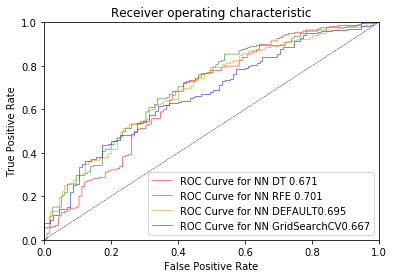

In [49]:
# Get graph
from sklearn.metrics import roc_curve
fpr_nnDT, tpr_nnDT, thresholds_nnDT = roc_curve(y_test, y_pred_proba_nnDT[:,1])
fpr_nnRFE, tpr_nnRFE, thresholds_nnRFE = roc_curve(y_test, y_pred_proba_nnRFE[:,1])
fpr_nnD, tpr_nnD, thresholds_nnD = roc_curve(y_test, y_pred_proba_nnD[:,1])
fpr_nnGS, tpr_nnGS, thresholds_nnGS = roc_curve(y_test, y_pred_proba_nnGS[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr_nnDT, tpr_nnDT, label='ROC Curve for NN DT {:.3f}'.format(roc_index_nnDT), color='red', lw=0.5)
plt.plot(fpr_nnRFE, tpr_nnRFE, label='ROC Curve for NN RFE {:.3f}'.format(roc_index_nnRFE), color='green', lw=0.5)
plt.plot(fpr_nnD, tpr_nnD, label='ROC Curve for NN DEFAULT{:.3f}'.format(roc_index_nnD), color='darkorange', lw=0.5)
plt.plot(fpr_nnGS, tpr_nnGS, label='ROC Curve for NN GridSearchCV{:.3f}'.format(roc_index_nnGS), color='blue', lw=0.5)
# plt.plot(fpr[2], tpr[2], color='darkorange',
# lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [50]:
#
# Start Task 5
#

In [58]:
# Task 5.1
# Best model accuracy and classification
y_pred_tree = tree_optimal.predict(x_test)
print("Accuracy score on test for Decision Tree:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))
analyse_feature_importance(tree_optimal, x.columns, 5)
print("\n")
print("Accuracy score on test for Neural RFE:", accuracy_score(y_test, y_pred_RFE))
print(classification_report(y_test, y_pred_RFE))
#
# Feature importance for NN
#
print("\n")
print("Accuracy score on test for Regression RFE:", accuracy_score(y_test, y_reg_rfe))
print(classification_report(y_test, y_reg_rfe))
# feature importance
coef = reg_rfe.coef_[0]
feature_names = x.columns
# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)
# dont limit so to see what variables are remaining
indices = indices[:5]
for i in indices:
    print(feature_names[i], ':', coef[i])

Accuracy score on test for Decision Tree: 0.643312101910828
             precision    recall  f1-score   support

          0       0.51      0.51      0.51       115
          1       0.72      0.72      0.72       199

avg / total       0.64      0.64      0.64       314

higher : 0.3133028333660085
school_DCHS : 0.131807588885754
absences : 0.11448145286961198
Fedu : 0.1088873310214518
traveltime : 0.07112199333165148


Accuracy score on test for Neural RFE: 0.7006369426751592
             precision    recall  f1-score   support

          0       0.66      0.38      0.48       115
          1       0.71      0.88      0.79       199

avg / total       0.69      0.70      0.68       314



Accuracy score on test for Regression RFE: 0.7038216560509554
             precision    recall  f1-score   support

          0       0.65      0.41      0.50       115
          1       0.72      0.87      0.79       199

avg / total       0.69      0.70      0.68       314

Pstatus : 0.259545449

In [56]:
# ROC Index
y = df['G3']
x = df.drop(['G3'], axis=1)
x_mat = x.as_matrix()
x_train, x_test, y_train, y_test = train_test_split(x_mat, y, test_size=0.3, stratify=y, random_state=rs)

y_pred_proba_tree = tree_optimal.predict_proba(x_test)
roc_index_tree = roc_auc_score(y_test, y_pred_proba_tree[:, 1])

print("ROC index on test for Decision Tree:", roc_index_tree)
print("ROC index on test for Neural RFE:", roc_index_nnRFE)
print("ROC index on test for Regression RFE:", roc_index_reg_rfe)

ROC index on test for Decision Tree: 0.6640375792003496
ROC index on test for Neural RFE: 0.7007646930303693
ROC index on test for Regression RFE: 0.6874371859296482


C:\Users\rickm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


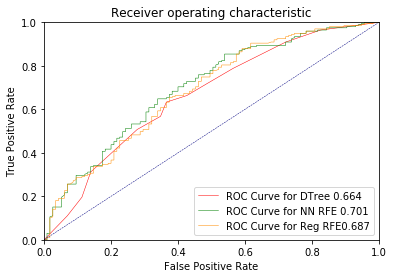

In [57]:
# ROC Chart
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_pred_proba_tree[:,1])

import matplotlib.pyplot as plt
plt.plot(fpr_tree, tpr_tree, label='ROC Curve for DTree {:.3f}'.format(roc_index_tree), color='red', lw=0.5)
plt.plot(fpr_nnRFE, tpr_nnRFE, label='ROC Curve for NN RFE {:.3f}'.format(roc_index_nnRFE), color='green', lw=0.5)
plt.plot(fpr_reg_rfe, tpr_reg_rfe, label='ROC Curve for Reg RFE{:.3f}'.format(roc_index_reg_rfe), color='darkorange', lw=0.5)
# plt.plot(fpr[2], tpr[2], color='darkorange',
# lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()